# CS5227 - Data Mining

## Group 9

### Kokularaj B. (239329T)
### Banujan C. (239306V)
### Ramsan M.M.M. (239348B)
### Lakmal D.K.D.L. (229415U)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [2]:
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from datetime import datetime
from datetime import time as tm
import pyarrow.parquet as pq

#from tqdm import tqdm
#from rich.progress import Progress
#import swifter

import dask.dataframe as dd
from dask.diagnostics import ProgressBar


import joblib

import polars as pl
from matplotlib.dates import date2num
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from io import StringIO

from sklearn.preprocessing import MinMaxScaler
import gc
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

#### Input Data

In [3]:
DATA_PATH = Path("/kaggle/input/child-mind-institute-detect-sleep-states")
TRAIN_EVENTS_PATH = DATA_PATH / "train_events.csv"
TRAIN_SERIES_PATH = DATA_PATH / "train_series.parquet"
TEST_SERIES_PATH = DATA_PATH / "test_series.parquet"
SAMPLE_SUBMISSION_PATH = DATA_PATH / "sample_submission.csv"

In [4]:
train_event_DF=pd.read_csv(TRAIN_EVENTS_PATH)

In [5]:
train_event_DF.head(10)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN


In [6]:
train_event_DF.shape

(14508, 5)

In [7]:
train_event_DF.head(10)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN


In [8]:
train_event_DF.dtypes

series_id     object
night          int64
event         object
step         float64
timestamp     object
dtype: object

In [9]:
train_series_DF=pd.read_parquet(TRAIN_SERIES_PATH)

In [10]:
type(train_series_DF.head(10))

pandas.core.frame.DataFrame

In [11]:
train_series_DF.shape

(127946340, 5)

In [12]:
test_series_DF=pd.read_parquet(TEST_SERIES_PATH)

In [13]:
test_series_DF.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [14]:
sample_submisstion_DF=pd.read_csv(SAMPLE_SUBMISSION_PATH)
sample_submisstion_DF.head(50)

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.0
1,1,038441c925bb,105,wakeup,0.0
2,2,03d92c9f6f8a,80,onset,0.5
3,3,03d92c9f6f8a,110,wakeup,0.5
4,4,0402a003dae9,90,onset,1.0
5,5,0402a003dae9,120,wakeup,1.0


### Data Cleansing and preprossing

In [15]:
# For the train event Data frame
missing_values_Train_event= train_event_DF.isna().sum()
print(missing_values_Train_event)

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64


In [16]:
print('The percentage of missing data in Train Event is {} %'.format(round((missing_values_Train_event['timestamp'] / train_event_DF.shape[0]) * 100, 2)))

The percentage of missing data in Train Event is 33.93 %


In [17]:
# For the train series Data frame
missing_values_Train_Series= train_series_DF.isna().sum()
print(missing_values_Train_Series)

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64


In [18]:
# For the test series Data frame
missing_values_Test_Series= test_series_DF.isna().sum()
print(missing_values_Test_Series)

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64


#### Fill the NAN value of Train Data event data frame

In [19]:
train_event_DF.shape

(14508, 5)

In [20]:
train_event_DF['timestamp'] = pd.to_datetime(train_event_DF['timestamp'], format='mixed', errors='coerce', dayfirst=True)

In [21]:
train_event_DF['timestamp'] = pd.to_datetime(train_event_DF['timestamp'], format='mixed', errors='coerce', dayfirst=True)

In [22]:
train_event_DF.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00-04:00


In [23]:
train_event_DF['Date'] = train_event_DF['timestamp'].dt.date
train_event_DF['Time'] = train_event_DF['timestamp'].dt.time

#### Onset time distribution curve

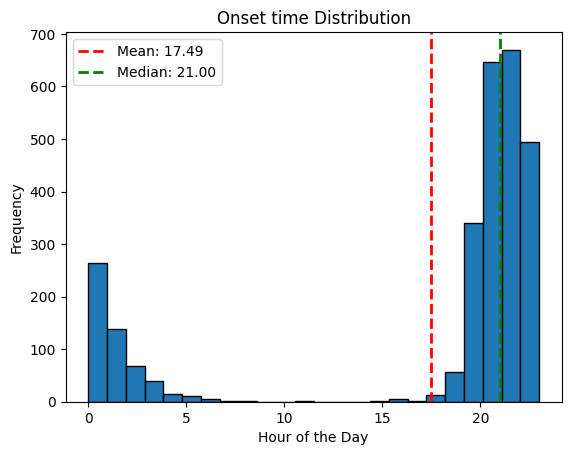

In [24]:
# Filter rows where the event is 'onset' and extract the hour component
onset_times = train_event_DF[train_event_DF['event'] == 'onset']['timestamp'].dropna().dt.hour

# Plot the onset time distribution
plt.hist(onset_times, bins=24, edgecolor='black')
plt.title('Onset time Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

# Plot mean and median as vertical lines
onset_mean_time = onset_times.mean()
onset_median_time = onset_times.median()

plt.axvline(onset_mean_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {onset_mean_time:.2f}')
plt.axvline(onset_median_time, color='green', linestyle='dashed', linewidth=2, label=f'Median: {onset_median_time:.2f}')

plt.legend()
plt.show()

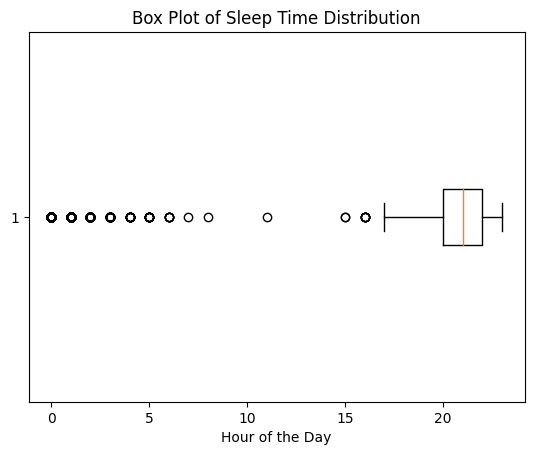

In [25]:
# Create a box plot
plt.boxplot(onset_times, vert=False)
plt.title('Box Plot of Sleep Time Distribution')
plt.xlabel('Hour of the Day')

plt.show()

* The onset distribution look like skewed

#### Handling Outliers

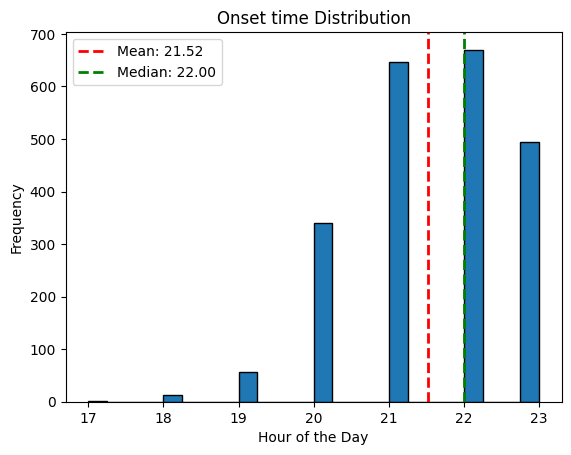

In [26]:
# Calculate the interquartile range (IQR)
onset_Q1 = onset_times.quantile(0.25)
onset_Q3 = onset_times.quantile(0.75)
onset_IQR = onset_Q3 - onset_Q1

# Define the lower and upper bounds to identify outliers
onset_lower_bound = onset_Q1 - 1.5 * onset_IQR
onset_upper_bound = onset_Q3 + 1.5 * onset_IQR

# Identify outliers
onset_outliers = (onset_times < onset_lower_bound) | (onset_times > onset_upper_bound)

# Remove outliers
onset_times_no_outliers = onset_times[~onset_outliers]



# Plot the onset time distribution
plt.hist(onset_times_no_outliers, bins=24, edgecolor='black')
plt.title('Onset time Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')


# Plot mean and median as vertical lines
onset_no_outliers_mean_time = onset_times_no_outliers.mean()
onset_no_outliers_median_time = onset_times_no_outliers.median()

plt.axvline(onset_no_outliers_mean_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {onset_no_outliers_mean_time:.2f}')
plt.axvline(onset_no_outliers_median_time, color='green', linestyle='dashed', linewidth=2, label=f'Median: {onset_no_outliers_median_time:.2f}')

plt.legend()
plt.show()


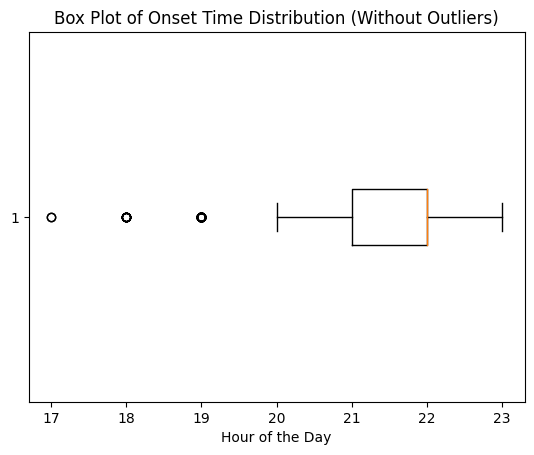

In [27]:
# Create a box plot without outliers
plt.boxplot(onset_times_no_outliers, vert=False)
plt.title('Box Plot of Onset Time Distribution (Without Outliers)')
plt.xlabel('Hour of the Day')

plt.show()

* Lakmal D.K.D.L. (229415U) proposed to fill the NA value with mean value
* Banujan C. (239306V) tried on Z-Score,but its not given proper output
* Ramsan M.M.M. (239348B) tried on winsorize,but its not given proper output
* Kokularaj B.(239329T) tried on quantile and the outcome satisfied
* Therefore we prefer the above method for the outlier capping
* The mean value of above plot is taken for to fill the NA value on the Train Data event

In [28]:
# Convert decimal hours to timedelta
onset_time_delta = timedelta(hours=onset_no_outliers_mean_time)

#Extract hours, minutes, and seconds from the timedelta
onset_hours, onset_remainder = divmod(onset_time_delta.seconds, 3600)
onset_minutes, onset_seconds = divmod(onset_remainder, 60)

print('The mean onset time is {} : {} :{} '.format(onset_hours,onset_minutes,onset_seconds))

The mean onset time is 21 : 31 :24 


#### Wakeup time distribution curve

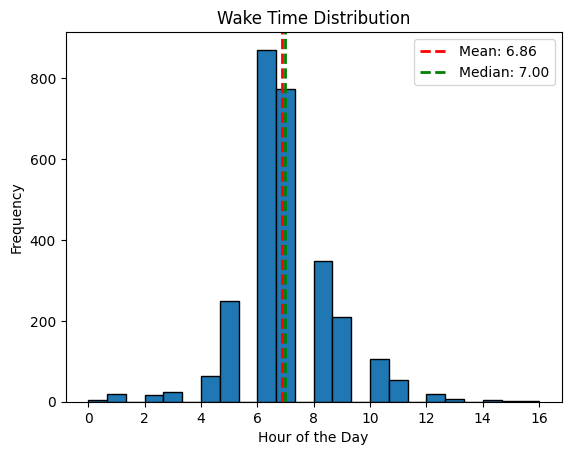

In [29]:
# Filter rows where the event is 'wakeup' and extract the hour component
wakeup_times = train_event_DF[train_event_DF['event'] == 'wakeup']['timestamp'].dropna().dt.hour

# Plot the sleep time distribution
plt.hist(wakeup_times, bins=24, edgecolor='black')
plt.title('Wake Time Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

# Plot mean and median as vertical lines
wakeup_mean_time = wakeup_times.mean()
wakeup_median_time = wakeup_times.median()

plt.axvline(wakeup_mean_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {wakeup_mean_time:.2f}')
plt.axvline(wakeup_median_time, color='green', linestyle='dashed', linewidth=2, label=f'Median: {wakeup_median_time:.2f}')

plt.legend()
plt.show()

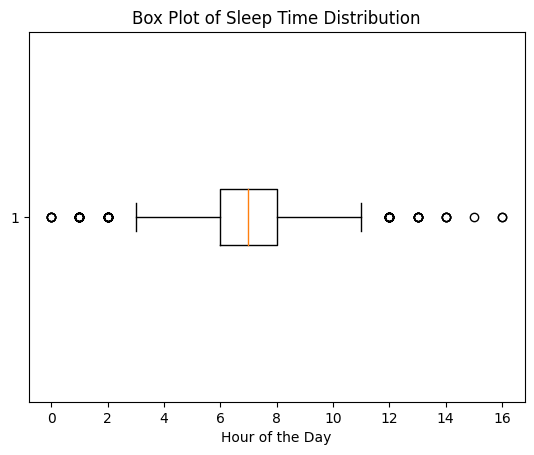

In [30]:
# Create a box plot
plt.boxplot(wakeup_times, vert=False)
plt.title('Box Plot of Sleep Time Distribution')
plt.xlabel('Hour of the Day')

plt.show()

* The distribution of wake-up times resembles a normal distribution
* The mean value of above plot is taken for to fill the NA value on the Train Data event

In [31]:
# Convert decimal hours to timedelta
wakeup_time_delta = timedelta(hours=wakeup_mean_time)

#Extract hours, minutes, and seconds from the timedelta
wakeup_hours, wakup_remainder = divmod(wakeup_time_delta.seconds, 3600)
wakeup_minutes, wakeup_seconds = divmod(wakup_remainder, 60)

print('The mean wakeup time is {} : {} :{} '.format(wakeup_hours,wakeup_minutes,wakeup_seconds))

The mean wakeup time is 6 : 51 :32 


### Fill the NA values in and Coloumns Time column in train_event_DF

In [32]:
train_event_DF.head(10)

,series_id,night,event,step,timestamp,Date,Time
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00-04:00,2018-08-14,22:26:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00-04:00,2018-08-15,06:41:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00-04:00,2018-08-15,19:37:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00-04:00,2018-08-16,05:41:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00-04:00,2018-08-16,23:03:00
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00-04:00,2018-08-17,05:10:00
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00-04:00,2018-08-17,23:00:00
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00-04:00,2018-08-18,06:48:00
8,038441c925bb,5,onset,NaN,NaT,NaT,NaT
9,038441c925bb,5,wakeup,NaN,NaT,NaT,NaT


In [33]:
#Find mean time in a time series
def meanTime(time_series):
    time_series = pd.to_datetime(time_series)
    # Convert datetime.time objects to total seconds since midnight
    time_series_seconds = time_series.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

    # Calculate the mean
    mean_seconds = time_series_seconds.mean()

    # Convert the mean back to datetime.time
    mean_time = datetime.utcfromtimestamp(mean_seconds).time()
    
    return mean_time


In [34]:
time_format = "%H:%M:%S"
#onset_time and wakeup_time
mean_onset_time=pd.to_datetime(f"{onset_hours}:{onset_minutes}:{onset_seconds}", format=time_format).strftime(time_format)
mean_wakeup_time=pd.to_datetime(f"{wakeup_hours}:{wakeup_minutes}:{wakeup_seconds}", format=time_format).strftime(time_format)

In [35]:
events={
    'onset':mean_onset_time,
    'wakeup':mean_wakeup_time
}

for i in range(2,train_event_DF.shape[0]):
    if pd.isna(train_event_DF.loc[i,'timestamp']):
        #Fill the Date Column
        if train_event_DF.loc[i-1,'Date']==train_event_DF.loc[i-2,'Date']:
            train_event_DF.loc[i,'Date']=train_event_DF.loc[i-1,'Date']+timedelta(days=1)
        else:
            train_event_DF.loc[i,'Date']=train_event_DF.loc[i-1,'Date']
        #Fill the time column  
        if train_event_DF.loc[i,'event']=='onset':
            train_event_DF.loc[i,'Time']=events['onset']
        elif train_event_DF.loc[i,'event']=='wakeup':
            train_event_DF.loc[i,'Time']=events['wakeup']
        

In [36]:
train_event_DF_cp=train_event_DF.copy()
train_event_DF_cp=train_event_DF_cp.drop(['step','timestamp'],axis=1)
train_event_DF_cp.head()

,series_id,night,event,Date,Time
0,038441c925bb,1,onset,2018-08-14,22:26:00
1,038441c925bb,1,wakeup,2018-08-15,06:41:00
2,038441c925bb,2,onset,2018-08-15,19:37:00
3,038441c925bb,2,wakeup,2018-08-16,05:41:00
4,038441c925bb,3,onset,2018-08-16,23:03:00


In [37]:
event_Dates = tqdm(train_event_DF['Date'].unique(), desc="Processing Dates")
sleepMem = {}

for date in event_Dates:
    onsetSeries = train_event_DF_cp[(train_event_DF_cp['Date'] == date) & (train_event_DF_cp['event'] == 'onset')]['Time']
    
    if not onsetSeries.empty:
        onsetSeries = pd.to_datetime(onsetSeries, format='%H:%M:%S').dt.time
        onsetSeries = onsetSeries.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
        onset_mean_time_seconds = onsetSeries.mean()
        onset_mean_time = tm(second=int(onset_mean_time_seconds % 60), minute=int((onset_mean_time_seconds // 60) % 60), hour=int(onset_mean_time_seconds // 3600))
    else:
        onset_mean_time = tm()

    wakeupSeries = train_event_DF_cp[(train_event_DF_cp['Date'] == date) & (train_event_DF_cp['event'] == 'wakeup')]['Time']
    
    if not wakeupSeries.empty:
        wakeupSeries = pd.to_datetime(wakeupSeries, format='%H:%M:%S').dt.time
        wakeupSeries = wakeupSeries.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
        wakeup_mean_time_seconds = wakeupSeries.mean()
        wakeup_mean_time = tm(second=int(wakeup_mean_time_seconds % 60), minute=int((wakeup_mean_time_seconds // 60) % 60), hour=int(wakeup_mean_time_seconds // 3600))
    else:
        wakeup_mean_time = tm()

    sleepMem[date] = {'onset': onset_mean_time, 'wakeup': wakeup_mean_time}

Processing Dates:   0%|          | 0/678 [00:00<?, ?it/s]

## Feature Engineering

* Use 1 set 1 million data in Train_Series for training

In [38]:
cropedRows=round(train_series_DF.shape[0]*.01)
cropedTrainSeriesData=train_series_DF[:cropedRows].copy()


In [39]:
cropedTrainSeriesData.shape

(1279463, 5)

In [40]:
cropedTrainSeriesData.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [41]:
cropedTrainSeriesData.dtypes

series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
dtype: object

In [42]:
cropedTrainSeriesData['timestamp'] = pd.to_datetime(cropedTrainSeriesData['timestamp'],utc=True)

In [43]:
cropedTrainSeriesData['Date'] = cropedTrainSeriesData['timestamp'].dt.date


In [44]:
cropedTrainSeriesData.head()

,series_id,step,timestamp,anglez,enmo,Date
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14


In [45]:
cropedTrainSeriesData['Time'] = cropedTrainSeriesData['timestamp'].dt.time

In [46]:
cropedTrainSeriesData.head()

,series_id,step,timestamp,anglez,enmo,Date,Time
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20


### Create "event" column in "train_series" Data set based on "train_event" data set

* Time between "onset" to "wakeup" in "train_event"  consider as "onset"
* Time between "wakeup" to "onset" in "train_event"  consider as "wakeup"

In [47]:
for i in tqdm(range(cropedTrainSeriesData.shape[0]), desc="Processing Data"):
    date = cropedTrainSeriesData.loc[i, 'Date']
    time = cropedTrainSeriesData.loc[i, 'Time']

    onset_time = sleepMem[date]['onset']
    wakeup_time = sleepMem[date]['wakeup']

    # If the time is less than wakeup time or greater than or equal to onset time, it should be onset
    # If the time is between wakeup and onset, it should be wakeup
    if time < wakeup_time or time >= onset_time:
        cropedTrainSeriesData.loc[i, 'event'] = 'onset'
    else:
        cropedTrainSeriesData.loc[i, 'event'] = 'wakeup'

Processing Data:   0%|          | 0/1279463 [00:00<?, ?it/s]

In [48]:
cropedTrainSeriesData[cropedTrainSeriesData['event']=='wakeup']

,series_id,step,timestamp,anglez,enmo,Date,Time,event
8527,038441c925bb,8527,2018-08-15 07:20:35+00:00,16.320400,0.0,2018-08-15,07:20:35,wakeup
8528,038441c925bb,8528,2018-08-15 07:20:40+00:00,16.237600,0.0,2018-08-15,07:20:40,wakeup
8529,038441c925bb,8529,2018-08-15 07:20:45+00:00,16.352800,0.0,2018-08-15,07:20:45,wakeup
8530,038441c925bb,8530,2018-08-15 07:20:50+00:00,16.367001,0.0,2018-08-15,07:20:50,wakeup
8531,038441c925bb,8531,2018-08-15 07:20:55+00:00,16.367800,0.0,2018-08-15,07:20:55,wakeup
...,...,...,...,...,...,...,...,...
1279458,0402a003dae9,165438,2018-12-28 07:31:30+00:00,57.196701,0.0,2018-12-28,07:31:30,wakeup
1279459,0402a003dae9,165439,2018-12-28 07:31:35+00:00,57.196701,0.0,2018-12-28,07:31:35,wakeup
1279460,0402a003dae9,165440,2018-12-28 07:31:40+00:00,57.196701,0.0,2018-12-28,07:31:40,wakeup
1279461,0402a003dae9,165441,2018-12-28 07:31:45+00:00,57.196701,0.0,2018-12-28,07:31:45,wakeup


In [49]:
cropedTrainSeriesData[cropedTrainSeriesData['event']=='onset']

,series_id,step,timestamp,anglez,enmo,Date,Time,event
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,2018-08-14,19:30:00,onset
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,2018-08-14,19:30:05,onset
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,2018-08-14,19:30:10,onset
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,2018-08-14,19:30:15,onset
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,2018-08-14,19:30:20,onset
...,...,...,...,...,...,...,...,...
1278974,0402a003dae9,164954,2018-12-28 06:51:10+00:00,58.963902,0.0000,2018-12-28,06:51:10,onset
1278975,0402a003dae9,164955,2018-12-28 06:51:15+00:00,58.961601,0.0000,2018-12-28,06:51:15,onset
1278976,0402a003dae9,164956,2018-12-28 06:51:20+00:00,58.962898,0.0000,2018-12-28,06:51:20,onset
1278977,0402a003dae9,164957,2018-12-28 06:51:25+00:00,58.962700,0.0000,2018-12-28,06:51:25,onset


### Create new feature "Season"

* Spring begins March 1 ~ May 31
* Summer begins June 1 August 31
* Autumn begins September 1 ~ November 30
* Winter begins December 1~Feb 28

# Created on one-encoding


In [50]:
cropedTrainSeriesData.head()


,series_id,step,timestamp,anglez,enmo,Date,Time,event
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,onset
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,onset
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,onset
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,onset
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,onset


In [51]:
# Convert the 'Date' column to datetime format
cropedTrainSeriesData['NewDate'] = pd.to_datetime(cropedTrainSeriesData['Date'])

# Create a new 'Season' column based on the month of each date
tqdm.pandas(desc="Mapping Seasons")
cropedTrainSeriesData['Season'] = cropedTrainSeriesData['NewDate'].dt.month.progress_map(lambda x: {3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                 9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
                                                 12: 'Winter', 1: 'Winter', 2: 'Winter'}.get(x))

# Use get_dummies to one-hot encode the 'Season' column
tqdm.pandas(desc="One-Hot Encoding")
season_dummies = cropedTrainSeriesData['Season'].progress_apply(lambda x: pd.Series({x: 1}))

Mapping Seasons:   0%|          | 0/1279463 [00:00<?, ?it/s]

One-Hot Encoding:   0%|          | 0/1279463 [00:00<?, ?it/s]

In [52]:
# Concatenate the one-hot encoded columns to the original DataFrame
cropedTrainSeriesData = pd.concat([cropedTrainSeriesData, season_dummies], axis=1)

In [53]:
cropedTrainSeriesData.head(25)

,series_id,step,timestamp,anglez,enmo,Date,Time,event,NewDate,Season,Summer,Autumn,Spring,Winter
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,2018-08-14,19:30:00,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,2018-08-14,19:30:05,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,2018-08-14,19:30:10,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,2018-08-14,19:30:15,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,2018-08-14,19:30:20,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
5,038441c925bb,5,2018-08-14 19:30:25+00:00,2.636700,0.0217,2018-08-14,19:30:25,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
6,038441c925bb,6,2018-08-14 19:30:30+00:00,2.636700,0.0217,2018-08-14,19:30:30,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
7,038441c925bb,7,2018-08-14 19:30:35+00:00,2.636700,0.0218,2018-08-14,19:30:35,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
8,038441c925bb,8,2018-08-14 19:30:40+00:00,2.798000,0.0223,2018-08-14,19:30:40,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN
9,038441c925bb,9,2018-08-14 19:30:45+00:00,3.084700,0.0217,2018-08-14,19:30:45,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN


### Use MinMaxScaler


In [54]:
# Create MinMaxScaler for anglez
anglezScaler = MinMaxScaler()

# Fit and transform the selected column
anglezCombained=pd.concat([cropedTrainSeriesData['anglez'], test_series_DF['anglez']])
anglezScaler.fit(anglezCombained.values.reshape(-1, 1))
cropedTrainSeriesData['anglezScaled']=anglezScaler.transform(cropedTrainSeriesData['anglez'].values.reshape(-1, 1))

In [55]:
cropedTrainSeriesData.head()


,series_id,step,timestamp,anglez,enmo,Date,Time,event,NewDate,Season,Summer,Autumn,Spring,Winter,anglezScaled
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517290
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289


In [56]:
# Create MinMaxScaler for enmo
enmoScaler = MinMaxScaler()

# Fit and transform the selected column
enmoCombained=pd.concat([cropedTrainSeriesData['enmo'], test_series_DF['enmo']])
enmoScaler.fit(anglezCombained.values.reshape(-1, 1))
cropedTrainSeriesData['enmoScaled']=anglezScaler.transform(cropedTrainSeriesData['enmo'].values.reshape(-1, 1))

In [57]:
cropedTrainSeriesData.head()


,series_id,step,timestamp,anglez,enmo,Date,Time,event,NewDate,Season,Summer,Autumn,Spring,Winter,anglezScaled,enmoScaled
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288,0.502686
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502685
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517290,0.502685
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502684
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502685


In [58]:
cropedTrainSeriesData['Date'] = pd.to_datetime(cropedTrainSeriesData['Date'])

# Add a new column 'weekday' to the DataFrame
cropedTrainSeriesData['weekday'] = cropedTrainSeriesData['Date'].dt.dayofweek

# Map the weekdays to 1 and weekends to 0
cropedTrainSeriesData['weekday'] = cropedTrainSeriesData['weekday'].apply(lambda x: 1 if x < 5 else 0)



In [59]:
cropedTrainSeriesData.head(10)

,series_id,step,timestamp,anglez,enmo,Date,Time,event,NewDate,Season,Summer,Autumn,Spring,Winter,anglezScaled,enmoScaled,weekday
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288,0.502686,1
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502685,1
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517290,0.502685,1
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502684,1
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502685,1
5,038441c925bb,5,2018-08-14 19:30:25+00:00,2.6367,0.0217,2018-08-14,19:30:25,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288,0.502686,1
6,038441c925bb,6,2018-08-14 19:30:30+00:00,2.6367,0.0217,2018-08-14,19:30:30,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288,0.502686,1
7,038441c925bb,7,2018-08-14 19:30:35+00:00,2.6367,0.0218,2018-08-14,19:30:35,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288,0.502687,1
8,038441c925bb,8,2018-08-14 19:30:40+00:00,2.7980,0.0223,2018-08-14,19:30:40,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.518189,0.502689,1
9,038441c925bb,9,2018-08-14 19:30:45+00:00,3.0847,0.0217,2018-08-14,19:30:45,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.519790,0.502686,1


#### Create feature for time sin and cos

In [60]:
cropedTrainSeriesData['Time'] = pd.to_datetime(cropedTrainSeriesData['Time'], format='%H:%M:%S')

In [61]:

#Extracting total seconds since midnight as a single feature
cropedTrainSeriesData['time_in_seconds'] = cropedTrainSeriesData['Time'].dt.hour * 3600 + cropedTrainSeriesData['Time'].dt.minute * 60 + cropedTrainSeriesData['Time'].dt.second

# Create empty columns for sin and cos
cropedTrainSeriesData['sin_time'] = np.nan
cropedTrainSeriesData['cos_time'] = np.nan

# Use tqdm to show a progress bar
for index, row in tqdm(cropedTrainSeriesData.iterrows(), total=cropedTrainSeriesData.shape[0], desc="Processing time features"):
    cropedTrainSeriesData.at[index, 'sin_time'] = np.sin(2 * np.pi * row['time_in_seconds'] / 86400)
    cropedTrainSeriesData.at[index, 'cos_time'] = np.cos(2 * np.pi * row['time_in_seconds'] / 86400)

Processing time features:   0%|          | 0/1279463 [00:00<?, ?it/s]

In [62]:
cropedTrainSeriesData.head()

,series_id,step,timestamp,anglez,enmo,Date,Time,event,NewDate,Season,Summer,Autumn,Spring,Winter,anglezScaled,enmoScaled,weekday,time_in_seconds,sin_time,cos_time
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,1900-01-01 19:30:00,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517288,0.502686,1,70200,-0.923880,0.382683
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,1900-01-01 19:30:05,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502685,1,70205,-0.923740,0.383019
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,1900-01-01 19:30:10,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517290,0.502685,1,70210,-0.923601,0.383355
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,1900-01-01 19:30:15,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502684,1,70215,-0.923462,0.383691
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,1900-01-01 19:30:20,onset,2018-08-14,Summer,1.0,NaN,NaN,NaN,0.517289,0.502685,1,70220,-0.923322,0.384027


In [63]:
#cropedTrainSeriesData.to_csv('cropedTrainSeries3.csv', index=False)

#### Feature engineering to test_series 

In [64]:
test_series_DF_CP=test_series_DF.copy()
del test_series_DF
gc.collect()

38

In [65]:
test_series_DF_CP.shape

(450, 5)

In [66]:
test_series_DF_CP['timestamp'] = pd.to_datetime(test_series_DF_CP['timestamp'],utc=True)
test_series_DF_CP['Date'] = test_series_DF_CP['timestamp'].dt.date
test_series_DF_CP['Time'] = test_series_DF_CP['timestamp'].dt.time
test_series_DF_CP.shape

(450, 7)

In [67]:
# Convert the 'Date' column to datetime format
test_series_DF_CP['NewDate'] = pd.to_datetime(test_series_DF_CP['Date'])

test_series_DF_CP.head()

,series_id,step,timestamp,anglez,enmo,Date,Time,NewDate
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,2018-08-14
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,2018-08-14
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,2018-08-14
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,2018-08-14
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,2018-08-14


In [68]:
# Create a new 'Season' column based on the month of each date
test_series_DF_CP['Season'] = test_series_DF_CP['NewDate'].dt.month.progress_map(lambda x: {3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                 9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
                                                 12: 'Winter', 1: 'Winter', 2: 'Winter'}.get(x))

# Use get_dummies to one-hot encode the 'Season' column
season_dummiesTest = test_series_DF_CP['Season'].progress_apply(lambda x: pd.Series({x: 1}))
test_series_DF_CP = pd.concat([test_series_DF_CP, season_dummiesTest], axis=1)


One-Hot Encoding:   0%|          | 0/450 [00:00<?, ?it/s]

One-Hot Encoding:   0%|          | 0/450 [00:00<?, ?it/s]

In [69]:
test_series_DF_CP.head()

,series_id,step,timestamp,anglez,enmo,Date,Time,NewDate,Season,Summer,Spring,Winter
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,2018-08-14,Summer,1.0,NaN,NaN
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,2018-08-14,Summer,1.0,NaN,NaN
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,2018-08-14,Summer,1.0,NaN,NaN
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,2018-08-14,Summer,1.0,NaN,NaN
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,2018-08-14,Summer,1.0,NaN,NaN


In [70]:
seasons=['Summer','Autumn','Spring','Winter']
for season in seasons:
    if season not in test_series_DF_CP.columns:
        test_series_DF_CP[season]=float('nan')

In [71]:
test_series_DF_CP['Date'] = pd.to_datetime(test_series_DF_CP['Date'])

# Add a new column 'weekday' to the DataFrame
test_series_DF_CP['weekday'] = test_series_DF_CP['Date'].dt.dayofweek

# Map the weekdays to 1 and weekends to 0
test_series_DF_CP['weekday'] = test_series_DF_CP['weekday'].apply(lambda x: 1 if x < 5 else 0)



In [72]:
test_series_DF_CP['anglezScaled']=anglezScaler.transform(test_series_DF_CP['anglez'].values.reshape(-1, 1))
test_series_DF_CP['enmoScaled']=anglezScaler.transform(test_series_DF_CP['enmo'].values.reshape(-1, 1))

In [73]:
test_series_DF_CP.head()

,series_id,step,timestamp,anglez,enmo,Date,Time,NewDate,Season,Summer,Spring,Winter,Autumn,weekday,anglezScaled,enmoScaled
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.6367,0.0217,2018-08-14,19:30:00,2018-08-14,Summer,1.0,NaN,NaN,NaN,1,0.517288,0.502686
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.6368,0.0215,2018-08-14,19:30:05,2018-08-14,Summer,1.0,NaN,NaN,NaN,1,0.517289,0.502685
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.6370,0.0216,2018-08-14,19:30:10,2018-08-14,Summer,1.0,NaN,NaN,NaN,1,0.517290,0.502685
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.6368,0.0213,2018-08-14,19:30:15,2018-08-14,Summer,1.0,NaN,NaN,NaN,1,0.517289,0.502684
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.6368,0.0215,2018-08-14,19:30:20,2018-08-14,Summer,1.0,NaN,NaN,NaN,1,0.517289,0.502685


In [74]:
test_series_DF_CP['Time'] = pd.to_datetime(test_series_DF_CP['Time'], format='%H:%M:%S')

#Extracting total seconds since midnight as a single feature
test_series_DF_CP['time_in_seconds'] = test_series_DF_CP['Time'].dt.hour * 3600 + test_series_DF_CP['Time'].dt.minute * 60 + test_series_DF_CP['Time'].dt.second

# Create empty columns for sin and cos
test_series_DF_CP['sin_time'] = np.nan
test_series_DF_CP['cos_time'] = np.nan

# Calculating sin and cos of time_in_seconds
test_series_DF_CP['sin_time'] = np.sin(2 * np.pi * test_series_DF_CP['time_in_seconds'] / 86400)  # 86400 seconds in a day
test_series_DF_CP['cos_time'] = np.cos(2 * np.pi * test_series_DF_CP['time_in_seconds'] / 86400)

### Model implementation

In [75]:
bestParams={'colsample_bytree': 0.8196022671113437,
 'gamma': 0.31417077398054244,
 'learning_rate': 0.22555374708267845,
 'max_depth': 2,
 'n_estimators': 135,
 'subsample': 0.8708780187253876}
xgb_classifier = XGBClassifier(**bestParams)
xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8196022671113437, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.31417077398054244, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22555374708267845, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=135, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [76]:
trainFeatures=['sin_time','cos_time','Summer','Autumn','Spring','Winter','anglezScaled','enmoScaled','weekday']

In [77]:
li=LabelEncoder()


In [78]:
X_train=cropedTrainSeriesData[trainFeatures].copy()
y_train=li.fit_transform(cropedTrainSeriesData['event'])
X_test=test_series_DF_CP[trainFeatures].copy()
del cropedTrainSeriesData
gc.collect()

55

In [79]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8196022671113437, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.31417077398054244, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22555374708267845, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=135, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [80]:
preditions=xgb_classifier.predict(X_test)
preditions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [81]:
preditions_lables=li.inverse_transform(preditions)
preditions_lables

array(['wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup',
       'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup',
       'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup',
       'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup', 'wakeup',
       'wakeup', 'wakeup', 'wakeup', 'wakeup', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'onset', 'onset', 'onset', 'onset', 'onset',
       'onset', 'onset', 'on

In [82]:
predict_proba=xgb_classifier.predict_proba(X_test)[:,1]
predict_proba

array([0.74979407, 0.74979407, 0.74979407, 0.74979407, 0.74979407,
       0.74979407, 0.74979407, 0.74979407, 0.74979407, 0.74979407,
       0.74979407, 0.74979407, 0.74979407, 0.74979407, 0.74979407,
       0.74979407, 0.74979407, 0.74979407, 0.794205  , 0.75174206,
       0.8269243 , 0.7013206 , 0.74142367, 0.8084589 , 0.789332  ,
       0.789332  , 0.789332  , 0.7803621 , 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631724,
       0.39631724, 0.39631724, 0.39631724, 0.39631724, 0.39631

In [83]:
submission=test_series_DF_CP[['series_id','step']].copy()
submission['event']=preditions_lables
submission['score']=predict_proba
submission['row_id'] = submission.index.astype(int)
submission = submission[['row_id','series_id','step','event','score']]

In [84]:
submission.to_csv('submission.csv')